# Introduction: Automated Hyperparameter Tuning

In this notebook, we will talk through a complete example of using automated hyperparameter tuning to optimize a machine learning model. In particular, we will use Bayesian Optimization and the Hyperopt library to tune the hyperparameters of a gradient boosting machine. 

__Additional Notebooks__ 

If you haven't checked out my other work on this problem, here is a complete list of the notebooks I have completed so far:

* [A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)
* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)

There are four approaches to tuning the hyperparameters of a machine learning model

1. __Manual__: select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat process until you run out of patience or are satisfied with the results.
2. __Grid Search__: set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!
3. __Random search__: set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.
4. __Automated Hyperparameter Tuning__: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.

These are listed in general order of least to most efficient. While we already conquered 2 and 3 [in this notebook](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search) (we didn't even try method 1), we have yet to take on automated hyperparameter tuning. There are a number of methods to do this including genetic programming, Bayesian optimization, and gradient based methods. Here we will focus only on Bayesian optimization, using the Tree Parzen Esimator (don't worry, you don't need to understand this in detail) in the [Hyperopt open-source Python library](https://hyperopt.github.io/hyperopt/).

For a little more background (we'll cover everything you need below), [here is an introductory article](https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0) on Bayesian optimization, and [here is an article on automated hyperparameter tuning](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a) using Bayesian optimization. Here we'll get right into automated hyperparameter tuning, so for the necessary background on model tuning, refer to [this kernel](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)

## Bayesian Optimization Primer

The problem with grid and random search is that these are __uninformed methods__ because they do not use the past results from different values of hyperparameters in the objective function (remember the objective function takes in the hyperparameters and returns the model cross validation score). We record the results of the objective function for each set of hyperparameters, but the algorithms do not select the next hyperparameter values from this information. Intuitively, if we have the past results, we should  use them to reason about what hyperparameter values work the best and choose the next values wisely to try and spend more iterations evaluating promising values. Evaluating hyperparameters in the objective function is very time-consuming, and the __concept of Bayesian optimization is to limit calls to the evaluation function by choosing the next hyperparameter values based on the previous results.__ This allows the algorithm to spend __more time evaluating promising hyperparameter values and less time in low-scoring regions of the hyperparameter space__. For example, consider the image below:

![](https://raw.githubusercontent.com/WillKoehrsen/hyperparameter-optimization/master/images/random_forest_hypothetical.png)

If you were choosing the next number of trees to try for the random forest, where would you concentrate your search? Probably around 100 trees because that is where the lowest errors have tended to occur (imagine this is a problem where we want to minimize the error). In effect, you have just done Bayesian hyperparameter optimization in your head! You formed a probability model of the error as a function of the hyperparameters and then selected the next hyperparameter values by maximizing the probability of a low error. Bayesian optimization works by building a surrogate function (in the form of a probability model) of the objective function $P(\text{score} | \text{hyperparameters}$. The surrogate function is much cheaper to evaluate than the objective, so the algorithm chooses the next values to try in the objective based on maximizing a criterion on the surrogate (usually expected improvement), exactly what you would have done with respect to the image above. 

The surrogate function is based on past evaluation results - pairs of (score, hyperparameter) records - and is continually updated with each objective function evaluation. Bayesian optimization therefore uses Bayesian reasoning: form an initial model (called a prior) and then update it with more evidence. The idea is that as the data accumulates, the surrogate function gets closer and closer to the objective function, and the hyperparameter values that are the best in the surrogate function will also do the best in the objective function. Bayesian optimization methods differ in the algorithm used to build the surrogate function and choose the next hyperparameter values to try. Some of the common choices are Gaussian Process (implemented in Spearmint), Random Forest Regression (in SMAC), and the Tree Parzen Estimator (TPE) in Hyperopt (technical details can be found in this article, although they won't be necessary to use the methods).

### Four Part of Bayesian Optimization

Bayesian hyperparameter optimization requires the same four parts as we implemented in grid and random search:

1. __Objective Function__: takes in an input (hyperparameters) and returns a score to minimize or maximize (the cross validation score)
2. __Domain space__: the range of input values (hyperparameters) to evaluate
3. __Optimization Algorithm__: the method used to construct the surrogate function and choose the next values to evaluate
4. __Results__: score, value pairs that the algorithm uses to build the surrogate function

The only differences are that now our objective function will return a score to minimize (this is just convention in the field of optimization), our domain space will be probability distributions rather than a hyperparameter grid, and the optimization algorithm will be an __informed method__ that uses past results to choose the next hyperparameter values to evaluate. 

## Hyperopt

Hyperopt is an open-source Python library the implements Bayesian Optimization using the Tree Parzen Estimator algorithm to construct the surrogate function and select the next hyperparameter values to evaluate in the objective function. There are a number of other libraries such as Spearmint (Guassian process surrogate function) and SMAC (random forest regression surrogate function) sharing the same problem structure. The four parts of an optimization problem that we develop here will apply to all the libraries with only a change in syntax. Morevoer, the optimization methods as applied to the Gradient Boosting Machine will translate to other machine learning models or any problem where we have to minimize a function.

### Gradient Boosting Machine

We will use the gradient booosting machine (GBM) as our model to tune in the LightGBM library. The GBM is our choice of model because it performs extremely well for these types of problems (as shown on the leaderboard) and because the performance is heavily dependent on the choice of hyperparameter values. 

For more details of the Gradient Boosting Machine (GBM), check out this high-level blog post, or this in depth technical article.

### Cross Validation with Early Stopping

As with random and grid search, we will evaluate each set of hyperparameters using 5 fold cross validation on the training data. The GBM model will be trained with early stopping, where estimators are added to the ensemble until the validation score has not decrease for 100 iterations (estimators added). 

Cross validation and early stopping will be implemented using the LightGBM `cv` function. We will use 5 folds and 100 early stopping rounds. 

#### Dataset and Approach

As before, we will work with a limited section of the data - 10000 observations for training and 6000 observations for testing. This will allow the optimization within the notebook to finish in a reasonable amount of time. Later in the notebook, I'll present results from 1000 iterations of Bayesian hyperparameter optimization on the reduced dataset and we then will see if these results translate to a full dataset (from [this kernel](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features)). The functions developed here can be taken and run on any dataset, or used with any machine learning model (just with minor changes in the details) and working with a smaller dataset will allow us to learn all of the concepts. I am currently running 500 iterations of Bayesian hyperparameter optimization on a complete dataset and will make the results available when the search is completed. 

With the background details out of the way, let's get started with Bayesian optimization applied to automated hyperparameter tuning! 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

C:\Users\Junbo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The code below reads in the data and creates a smaller version for training and a set for testing. We can only use the training data __a single time__ when we evaluate the final model. Hyperparameter tuning must be done on the training data using cross validation!

In [2]:
features = pd.read_csv('D:/home-credit-default-risk/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
99825,2,99000.0,562491.0,27189.0,454500.0,0.007330,-10901,-603,-574.0,-3572,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
208378,0,157500.0,677664.0,34731.0,585000.0,0.024610,-12091,-1358,-2918.0,-3715,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
1309,2,112500.0,864000.0,25393.5,864000.0,0.028663,-11922,-1868,-1465.0,-4580,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
172223,1,63000.0,180000.0,9000.0,180000.0,0.020246,-14570,-7753,-5007.0,-4719,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
258157,0,202500.0,1193580.0,42417.0,855000.0,0.020713,-20925,-1049,-3149.0,-4437,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Baseline Model 

First we can create a model with the default value of hyperparameters and score it using cross validation with early stopping. Using the `cv` LightGBM function requires creating a `Dataset`.

In [3]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [4]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

C:\Users\Junbo\Anaconda3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


The maximium ROC AUC in cross validation was 0.71183 with std of 0.01699.
The ideal number of iterations was 19.


Now we can evaluate the baseline model on the testing data.

In [5]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71981 ROC AUC on the test set.


# Objective Function

The first part to write is the objective function which takes in a set of hyperparameter values and returns the cross validation score on the training data. An objective function in Hyperopt must return either a single real value to minimize, or a dictionary with a key "loss" with the score to minimize (and a key "status" indicating if the run was successful or not). 

Optimization is typically about minimizing a value, and because our metric is Receiver Operating Characteristic Area Under the Curve (ROC AUC) where higher is better, the objective function will return $1 - \text{ROC AUC Cross Validation}$. The algorithm will try to drive this value as low as possible (raising the ROC AUC) by choosing the next hyperparameters based on the past results. 

The complete objective function is shown below. As with random and grid search, we write to a `csv` file on each call of the function in order to track results as the search progress and so we have a saved record of the search. (The `subsample` and `boosting_type` logic will be explained when we get to the domain). 

In [6]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

# Domain 

Specifying the domain (called the space in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images!

In [7]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

First we will go through an example of the learning rate. We are using a log-uniform space for the learning rate defined from 0.005 to 0.5. The log - uniform distribution has the values evenly placed in logarithmic space rather than linear space. This is useful for variables that differ over several orders of magnitude such as the learning rate. For example, with a log-uniform distribution, there will be an equal chance of drawing a value from 0.005 to 0.05 and from 0.05 to 0.5 (in linear space far more values would be drawn from the later since the linear distance is much larger. The logarithmic space is exactly the same - a factor of 10).

In [8]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

We can visualize the learning rate by drawing 10000 samples from the distribution.

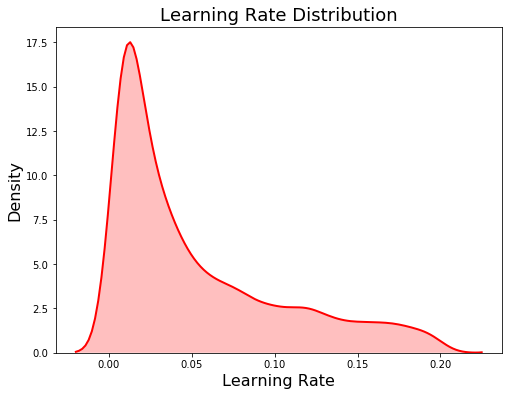

In [9]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

The number of leaves on the other hand is a discrete uniform distribution.

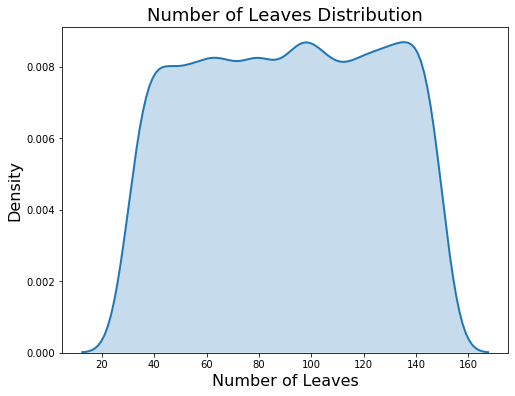

In [10]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Conditional Domain

In Hyperopt, we can use nested conditional statements to indicate hyperparameters that depend on other hyperparameters. For example, the "goss" `boosting_type` cannot use subsampling, so when we set up the `boosting_type` categorical variable, we have to set the subsample to 1.0 while for the other boosting types it's a float between 0.5 and 1.0.

In [11]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.9680357950421725}}

We need to set both the boosting_type and subsample as top-level keys in the parameter dictionary. We can use the Python dict.get method with a default value of 1.0. This means that if the key is not present in the dictionary, the value returned will be the default (1.0).

In [12]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'gbdt', 'subsample': 0.9680357950421725}

The gbm cannot use the nested dictionary so we need to set the `boosting_type` and `subsample` as top level keys. 

Nested conditionals allow us to use a different set of hyperparameters depending on other hyperparameters. For example, we can explore different models with completely different sets of hyperparameters by using nested conditionals. The only requirement is that the first nested statement must be based on a choice hyperparameter (the choice could be the type of model).

## Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the choice variable. Other variables types include quniform, loguniform, and uniform. For the complete list, check out the documentation for Hyperopt. Altogether there are 10 hyperparameters to optimize. 

In [13]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

### Example of Sampling from the Domain

Let's sample from the domain (using the conditional logic) to see the result of each draw. Every time we run this code, the results will change. (Again notice that we need to assign the top level keys to the keywords understood by the GBM).

In [14]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'goss',
 'colsample_bytree': 0.8724157844889451,
 'is_unbalance': False,
 'learning_rate': 0.02032909354742687,
 'min_child_samples': 220.0,
 'num_leaves': 25.0,
 'reg_alpha': 0.3733349397184823,
 'reg_lambda': 0.8895264493539569,
 'subsample_for_bin': 80000.0,
 'subsample': 1.0}

In [15]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7629325689820508,
 'is_unbalance': True,
 'learning_rate': 0.4555062573611794,
 'min_child_samples': 45.0,
 'num_leaves': 52.0,
 'reg_alpha': 0.17647148272644264,
 'reg_lambda': 0.38544972924284615,
 'subsample_for_bin': 200000.0,
 'subsample': 0.7847130829300444}

Let's test the objective function with the domain to make sure it works. (Every time the `of_connection` line is run, the `outfile` will be overwritten, so use a different name for each trial to save the results.)

In [16]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.32244.
The optimal number of estimators was 2.


# Optimization Algorithm

The optimization algorithm is the method for constructing the surrogate function (probability model) and selecting the next set of hyperparameters to evaluate in the objective function. Hyperopt has two choices: random search and Tree Parzen Estimator. 

The technical details of TPE can be found in [this article](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) and a conceptual explanation is in [this article](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f). Although this is the most technical part of Bayesian hyperparameter optimization, defining the algorithm in Hyperopt is simple. 

In [17]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

# Results History
The final part is the history of objective function evaluations. Although Hyperopt internally keeps track of the results for the algorithm to use, if we want to monitor the results and have a saved copy of the search, we need to store the results ourselves. Here, we are using two methods to make sure we capture all the results:

1. A `Trials` object that stores the dictionary returned from the objective function
2. Adding a line to a csv file every iteration.

The csv file option also lets us monitor the results of an on-going experiment. Although do not use Excel to open the file while training is on-going. Instead check the results using `tail results/out_file.csv` from bash or open the file in Sublime Text or Notepad.

In [26]:
from hyperopt import Trials

# Record results
trials = Trials()

The `Trials` object will hold everything returned from the objective function in the `.results` attribute. We can use this after the search is complete to inspect the results, but an easier method is to read in the `csv` file because that will already be in a dataframe.

In [27]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Automated Hyperparameter Optimization in Practice

We have all four parts we need to run the optimization. To run Bayesian optimization we use the `fmin` function (a good reminder that we need a metric to minimize!) 

In [28]:
from hyperopt import fmin

`fmin` takes the four parts defined above as well as the maximum number of iterations `max_evals`. 

In [29]:
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

100%|██████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/trial, best loss: 0.2726466009464743]


{'boosting_type': 0,
 'colsample_by_tree': 0.8977166215921235,
 'gdbt_subsample': 0.7944565022858381,
 'is_unbalance': 1,
 'learning_rate': 0.13902228663536867,
 'min_child_samples': 490.0,
 'num_leaves': 70.0,
 'reg_alpha': 0.019880672121159848,
 'reg_lambda': 0.9696593869146303,
 'subsample_for_bin': 140000.0}

The `best` object holds only the hyperparameters that returned the lowest loss in the objective function. Although this is ultimately what we are after, if we want to understand how the search progresses, we need to inspect the `Trials` object or the `csv` file. For example, we can sort the `results` returned from the objective function by the lowest loss:

In [30]:
# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'loss': 0.2726466009464743,
  'hyperparameters': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.8977166215921235,
   'is_unbalance': False,
   'learning_rate': 0.13902228663536867,
   'min_child_samples': 490,
   'num_leaves': 70,
   'reg_alpha': 0.019880672121159848,
   'reg_lambda': 0.9696593869146303,
   'subsample_for_bin': 140000,
   'subsample': 0.7944565022858381,
   'n_estimators': 21},
  'iteration': 3,
  'train_time': 1.5298394000000002,
  'status': 'ok'}]

An easier method is to read in the csv file since this will be a dataframe. 

In [31]:
results = pd.read_csv(OUT_FILE)

The function below takes in the results, trains a model on the training data, and evalutes on the testing data. It returns a dataframe of hyperparameters from the search. 

Saving the results to a csv file converts the dictionary of hyperparameters to a string. We need to map this back to a dictionary using `ast.literal_eval`. 

In [32]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [33]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.72735 found on iteration 3.
ROC AUC from Bayesian on test data = 0.73531.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,n_estimators,iteration,score
0,gbdt,0.897717,False,0.139022,490,70,0.019881,0.969659,140000,0.794457,21,3,0.727353
1,gbdt,0.707568,False,0.356643,470,44,0.812461,0.943199,260000,0.670234,11,4,0.718023
2,goss,0.957441,False,0.039303,355,122,0.536831,0.363302,160000,1.000000,23,2,0.717833
3,goss,0.939247,False,0.285363,335,127,0.967588,0.209899,40000,1.000000,3,1,0.711117
4,goss,0.993788,True,0.256322,380,134,0.080966,0.912450,100000,1.000000,3,5,0.706990


## Continue Optimization

Hyperopt can continue searching where a previous search left off if we pass in a `Trials` object that already has results. The algorithms used in Bayesian optimization are black-box optimizers because they have no internal state. All they need is the previous results of objective function evaluations (the input values and loss) and they can build up the surrogate function and select the next values to evaluate in the objective function. This means that any search can be continued as long as we have the history in a `Trials` object. 

In [52]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

 80%|████████████████████████████████████████████████████████████               | 8/10 [00:00<?, ?trial/s, best loss=?]


To save the `Trials` object so it can be read in later for more training, we can use the `json` format. 

In [53]:
lgb.

<_io.TextIOWrapper name='C:\\Users\\Junbo\\Anaconda3\\lib\\site-packages\\lightgbm\\VERSION.txt' mode='r' encoding='cp936'>

In [56]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

To start the training from where it left off, simply load in the `Trials` object and pass it to an instance of `fmin`. (You might even be able to tweak the hyperparameter distribution and continue searching with the `Trials` object because the algorithm does not maintain an internal state. Someone should check this and let me know in the comments!).

## Next Steps

Now that we have developed all the necessary parts for automated hyperparameter tuning using Bayesian optimization, we can apply these to any dataset or any machine learning method. The functions taken here can be put in a script and run a full dataset. Next, we will go through results from 1000 evaluations on a reduced size dataset to see how the search progresses. We can then compare these results to random search to see how a method that uses __reasoning__ about past results differs from a method that does not. 

After examining the tuning results from the reduced dataset, we will take the best performing hyperparameters and see if these translate to a full dataset, the features from the `[Updated 0.792 LB] LightGBM with Simple Features`(https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) kernel (I did not develop these features and want to give credit to the numerous people, including [Aguiar](https://www.kaggle.com/jsaguiar) and [olivier](https://www.kaggle.com/ogrellier),  who have worked on these features. Please check out their [kernels](https://www.kaggle.com/ogrellier/lighgbm-with-selected-features)!). We saw in the random and grid search notebook that the best hyperparameter values from the small datasets do not necessarily perform well on the full datasets. I am currently running the Bayesian Hyperparameter optimization for 500 iterations on the features referenced above and will make the results publicly available when the search is finished. For now, we will turn to the 1000 trials from the smaller dataset. These results can be generated by running the cell below, but I can't guarantee if this will finish within the kernel time limit! 

In [57]:
# MAX_EVALS = 1000

# # Create a new file and open a connection
# OUT_FILE = 'bayesian_trials_1000.csv'
# of_connection = open(OUT_FILE, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
# writer.writerow(headers)
# of_connection.close()

# # Record results
# trials = Trials()

# global ITERATION

# ITERATION = 0 

# best = fmin(fn = objective, space = space, algo = tpe.suggest,
#             trials = trials, max_evals = MAX_EVALS)

# # Sort the trials with lowest loss (highest AUC) first
# trials_dict = sorted(trials.results, key = lambda x: x['loss'])

# print('Finished, best results')
# print(trials_dict[:1])

# # Save the trial results
# with open('trials.json', 'w') as f:
#     f.write(json.dumps(trials_dict))

# Search Results 

Next we will go through the results from 1000 search iterations on the reduced dataset. We will look at the scores, the distribution of hyperparameter values tried, the evolution of values over time, and compare the hyperparameters values to those from random search.

After examining the search results, we will use the optimized hyperparameters (at least optimized for the smaller dataset) to make predictions on a full dataset. These can then be submitted to the competition to see how well the methods do on a small sample of the data.

## Learning Rate Distribution 

In [58]:
bayes_results = pd.read_csv('D:/home-credit-default-risk/bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results = pd.read_csv('D:/home-credit-default-risk/random_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results['loss'] = 1 - random_results['score']

bayes_params = evaluate(bayes_results, name = 'Bayesian')
random_params = evaluate(random_results, name = 'random')

The highest cross validation score from Bayesian was 0.72975 found on iteration 750.
ROC AUC from Bayesian on test data = 0.73335.
The highest cross validation score from random was 0.73448 found on iteration 596.
ROC AUC from random on test data = 0.72822.


We can see that the Bayesian search did worse in cross validation but then found hyperparameter values that did better on the test set! We will have to see if these results translate to the acutal competition data. First though, we can get all the scores in a dataframe in order to plot them over the course of training.

In [59]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': random_params['score'], 'iteration': random_params['iteration'], 'search': 'Random'})
scores = scores.append(pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.734484,596,Random
1,0.734312,292,Random
2,0.734079,281,Random
3,0.734025,349,Random
4,0.733680,538,Random


We can also find the best scores for plotting the best hyperparameter values.

In [60]:
best_random_params = random_params.iloc[random_params['score'].idxmax(), :].copy()
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

Below is the code showing the progress of scores versus the iteration. For random search we do not expect to see a pattern, but for Bayesian optimization, we expect to see the scores increasing with the search as more promising hyperparameter values are tried.

C:\Users\Junbo\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


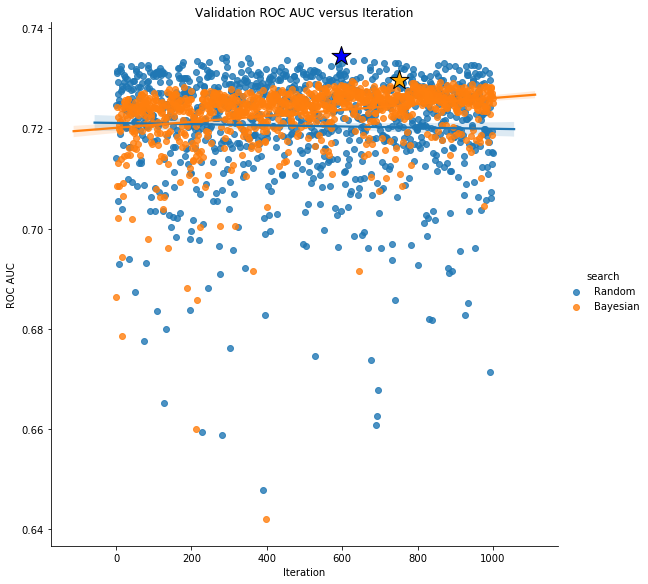

In [61]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_random_params['iteration'], best_random_params['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

Sure enough, we see that the Bayesian hyperparameter optimization scores increase as the search continues. This shows that more promising values (at least on the cross validation reduced dataset) were tried as the search progressed. Random search does record a better score, but the results do not improve over the course of the search. In this case, it looks like if we were to continue searching with Bayesian optimization, we would eventually reach higher scores on the cross vadidation data. 

For fun, we can make the same plot in Altair.

In [62]:
# pip install vega==1.3

In [63]:
import altair as alt

# alt.renderers.enable('notebook')

c = alt.Chart(scores).mark_circle().encode(x = 'iteration', y = alt.Y('ROC AUC', 
                                                                  scale = alt.Scale(domain = [0.64, 0.74])),
                                       color = 'search')
c.title = 'Validation ROC AUC vs Iteration'
c

alt.Chart(...)

Same chart, just in a different library for practice! 

## Learning Rate Distribution

Next we can start plotting the distributions of hyperparameter values searched. We expect random search to align with the search domain, while the Bayesian hyperparameter optimization should tend to focus on more promising values, wherever those happen to be in the search domain.

The dashed vertical lines indicate the "optimal" value of the hyperparameter.

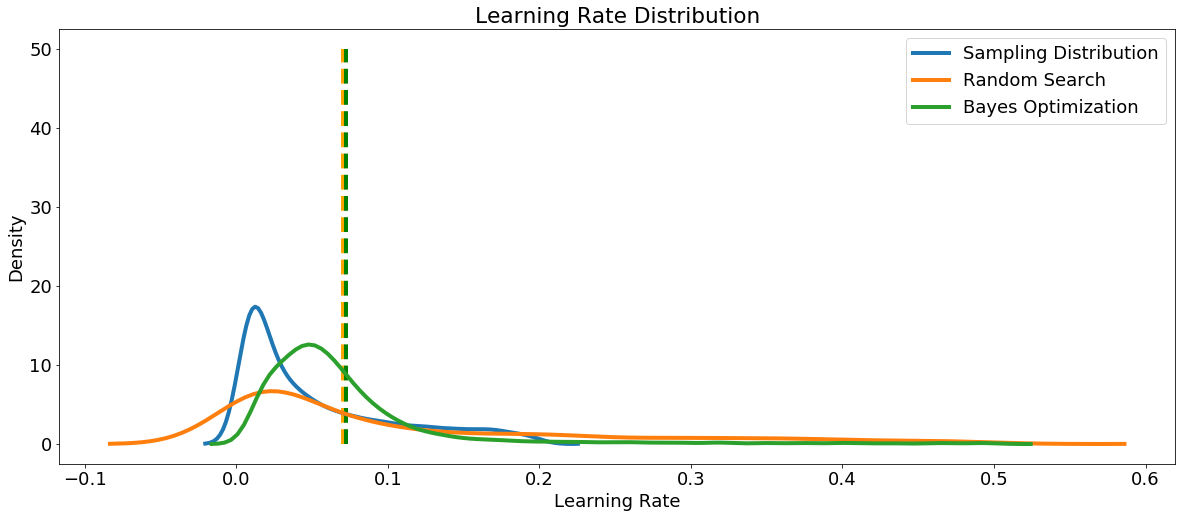

In [64]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

## Distribution of all Numeric Hyperparameters

We can make the same chart now for all of the hyperparameters. For each setting, we plot the values tried by random search and bayesian optimization, as well as the sampling distirbution.

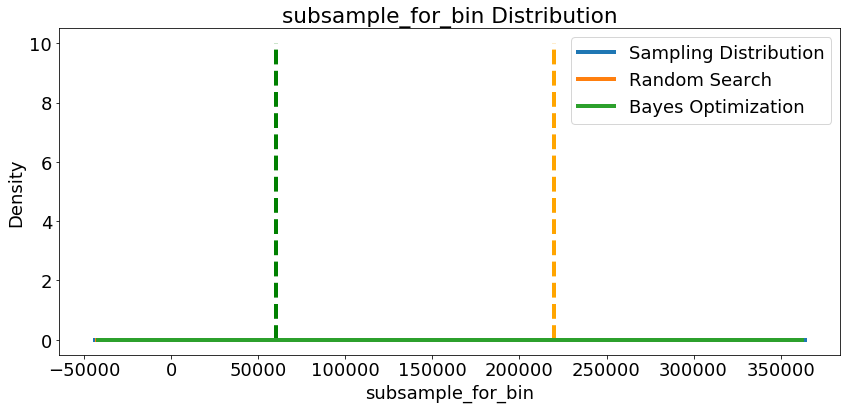

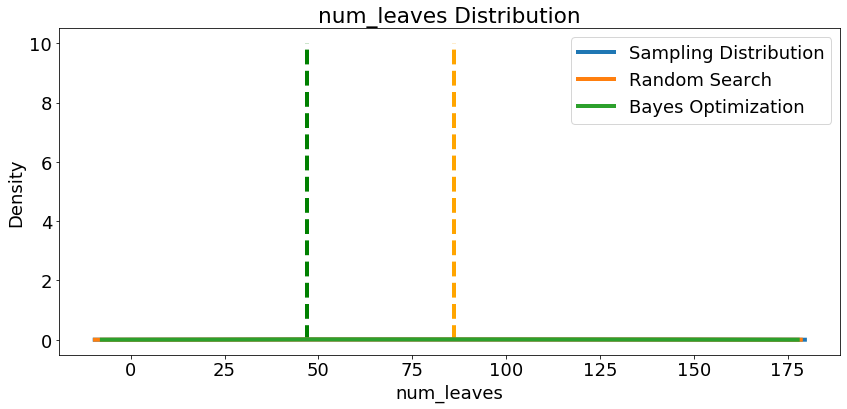

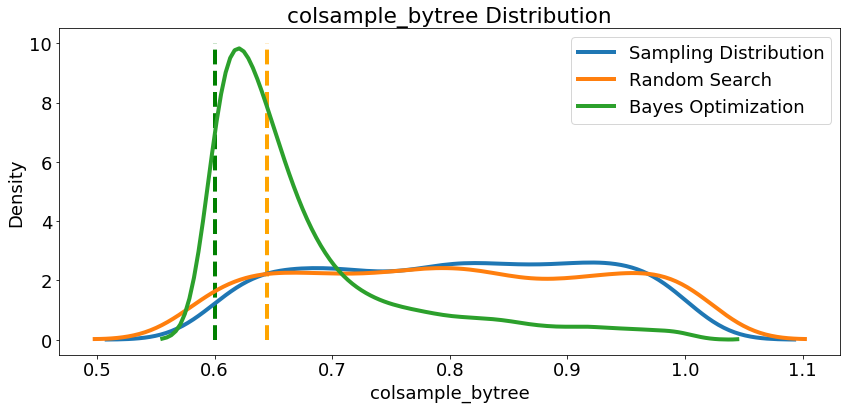

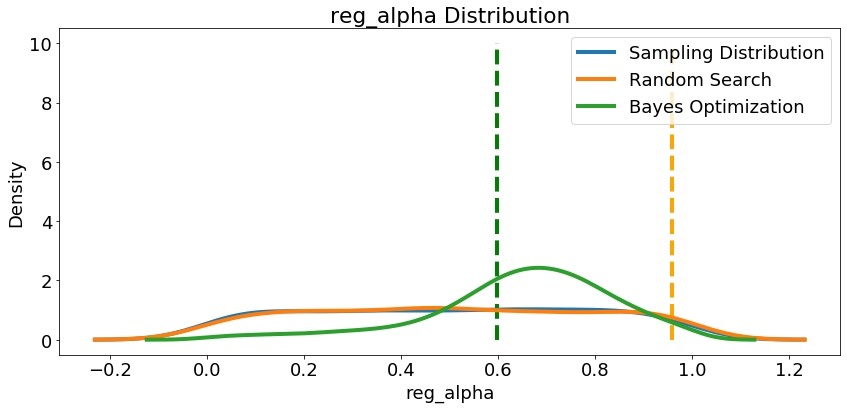

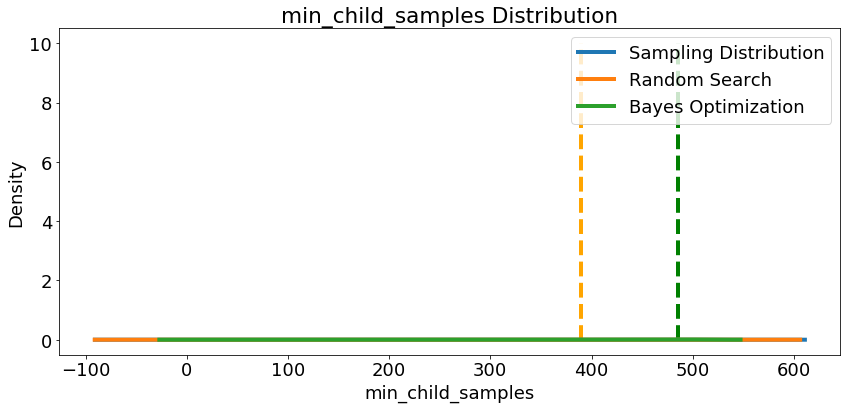

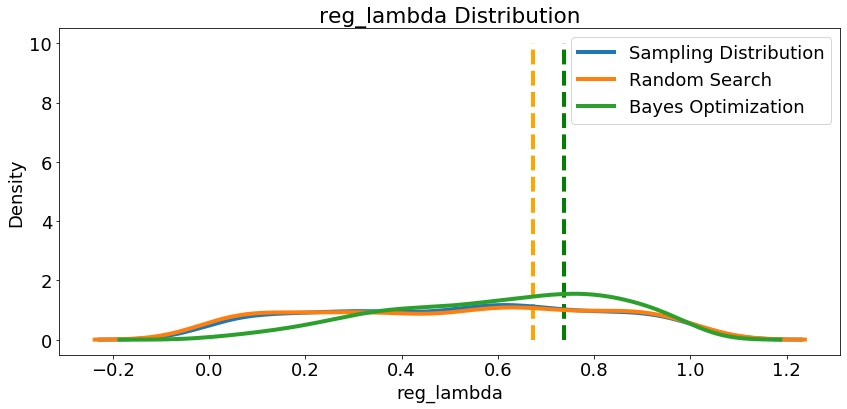

In [65]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'score', 'is_unbalance',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

## Evolution of Search

An interesting series of plots to make is the evolution of the hyperparameters over the search. This can show us what values the Bayesian optimization tended to focus on. The average cross validation score continued to improve throughout Bayesian optimization, indicating that "more promising" values of the hyperparameters were being evaluated and maybe a longer search would prove useful (or there could be a plateau in the validation scores with a longer search).

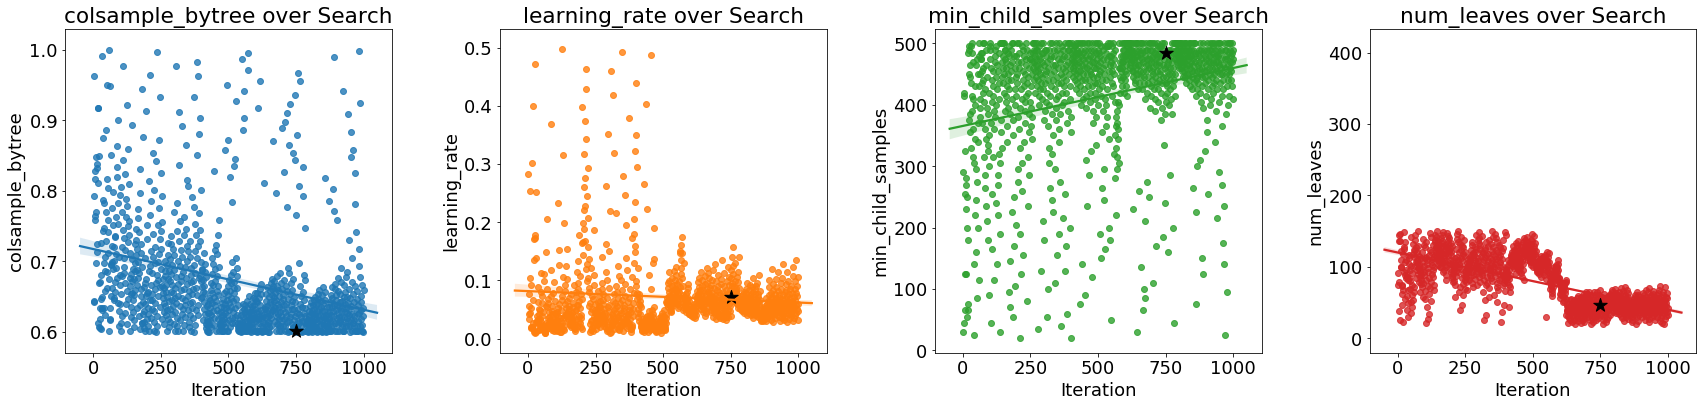

In [66]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

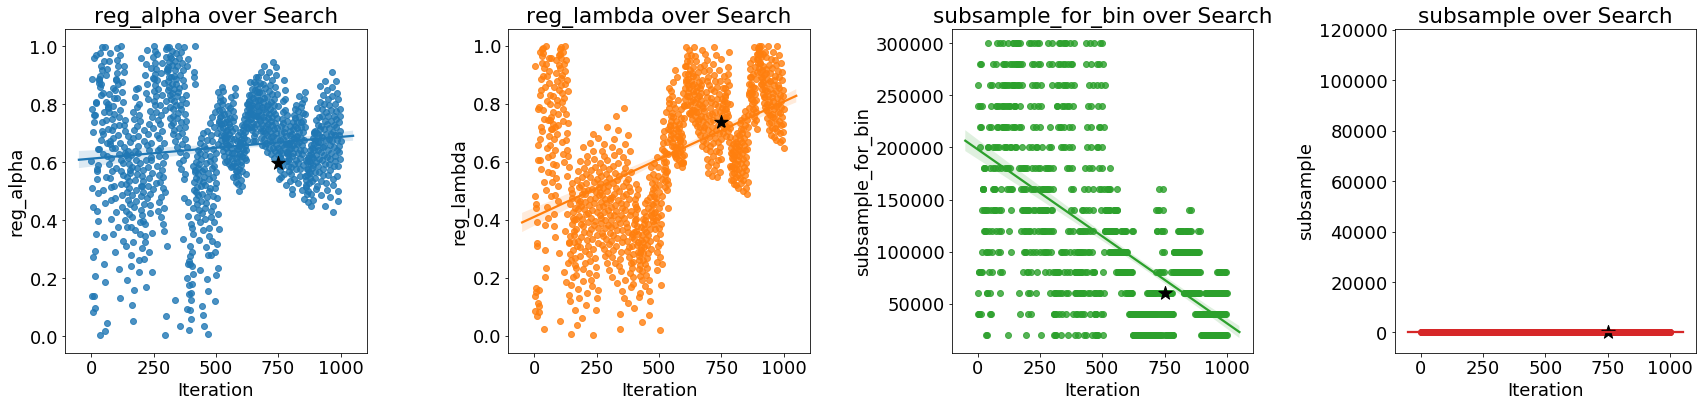

In [67]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

The final plot is just a bar chart of the `boosting_type`. 

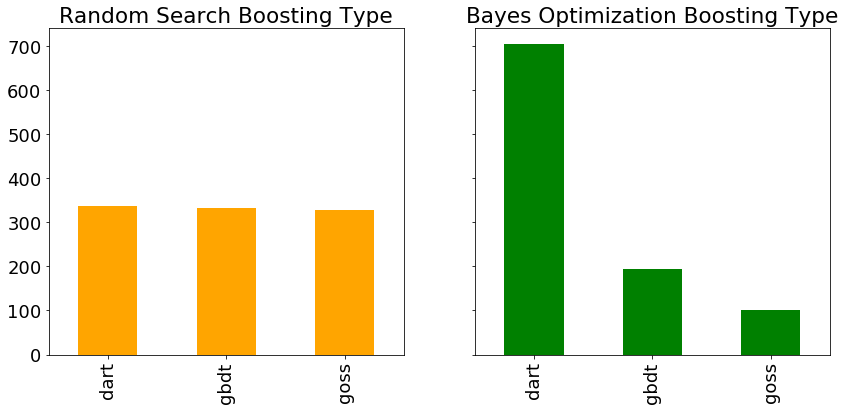

In [68]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

The Bayes optimization spent many more iterations using the `dart` boosting type than would be expected from a uniform distribution. We can use information such as this in further hyperparameter tuning. For example, we could use the distributions from Bayesian hyperparameter optimization to make a more focused hyperparameter grid for grid or even random search. 

![](http://)For this chart, we can also make it in Altair for the practice.

In [69]:
bars = alt.Chart(random_params, width = 500).mark_bar(color = 'orange').encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 400])))
text = bars.mark_text(size = 20, align = 'center', baseline = 'bottom').encode(text = 'count()')

bars + text

alt.LayerChart(...)

In [70]:
bars = alt.Chart(bayes_params, width = 500).mark_bar(color = 'green').encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 800])))
text = bars.mark_text(size = 20, align = 'center', baseline = 'bottom').encode(text = 'count()')

bars + text

alt.LayerChart(...)

## Applied to Full Dataset

Now, we can take the best hyperparameters found from 1000 iterations of Bayesian hyperparameter optimization on the smaller dataset and apply these to a full dataset of features from the `[Updated 0.792 LB] LightGBM with Simple Features`(https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) kernel. The best hyperparameters from the smaller dataset will not necessarily be the best on the full dataset (because the small dataset does nto perfectly represent the entire data), but we can at least try them out. We will train a model using the optimal hyperparameters from Bayesian optimization using early stopping to determine the number of estimators. 

In [71]:
# Read in full dataset
train = pd.read_csv('D:/home-credit-default-risk/simple_features_train.csv')
test = pd.read_csv('D:/home-credit-default-risk/simple_features_test.csv')

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307507, 718)
Testing shape:  (48744, 718)


In [72]:
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)
bayes_results['hyperparameters'] = bayes_results['hyperparameters'].map(ast.literal_eval)

### Random Search on the Full Dataset

In [73]:
train_set = lgb.Dataset(train, label = train_labels)

hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset  for Random Search= {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

LightGBMError: Do not support special JSON characters in feature name.

Then we can make predictions on the test data. The predictions are saved to a csv file that can be submitted to the competition.

In [74]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_random_search.csv', index = False)

LightGBMError: Do not support special JSON characters in feature name.

Submitting these to the competition results in a score of __0.787__ which compares to the original score from the kernel of __0.792__

### Bayesian Optimization on the Full Dataset

In [ ]:
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

C:\Users\Junbo\Anaconda3\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


In [ ]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_bayesian_optimization.csv', index = False)

Submitting these to the competition results in a score of __0.792__. So the Bayesian optimization outperforms the random search based on 1000 iterations on a reduced sized dataset. I wouldn't put too much weight into these results because we saw that random search actually yielded a higher cross validation score. Nonetheless, Bayesian hyperparameter optimization can be an effective technique for automated machine learning model tuning.

# Conclusions

Bayesian optimization is one method for automated hyperparameter tuning. Automated hyperparameter tuning aims to find the best hyperparameter values for a machine learning model on a given dataset with no input from the data scientist beyond initial set-up required. Bayesian optimization uses Bayesian reasoning to build a probability model of the objecitve function $P(\text{score} | \text{hyperparameters})$ which is then used to select the next hyperparameter values to evaluate. The concept is to use more search iterations evaluating promising hyperparameter values by reasoning from the past results. This is an intuitive method of hyperparamter optimization that works in much the same way a human does to get better at any situation: learn from past experiences! If everything works as expected, Bayesian hyperparameter optimization can result in:

* Better generalization performance on the test set
* Fewer iterations than random or grid search require

Even if Bayesian optimization (or other automated hyperparameter tuning methods) does not deliver on the above points in all situations, it is a useful skill to master as a data scientist. In the future, data scientists are not going to spend valuable time tweaking model hyperparameters, and knowing methods for accomplishing this automatically will go a long way in your career or studies! Feel free to take this code and apply it to any dataset or to a different machine learning model. I am currently running these methods on a full dataset and will share the results when they are completed. I look forward to the next notebook! 

As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will. Thanks for reading to the end and keep making the data science community such a wonderful place for learning and sharing, 

Will